# Binary Classification with IMDb Dataset

## Introduction
In this notebook, I will be working with the **IMDb movie review dataset** from **Hugging Face**. This dataset consists of **two classes**: **positive** and **negative** reviews, making it a **binary classification task**.

## Objective
The goal is to **fine-tune a transformer-based pre-trained model** to classify movie reviews as either **positive or negative**. This approach leverages **transfer learning** to improve performance with minimal training time.

## Workflow:
1. **Load the IMDb dataset** from Hugging Face.
2. **Preprocess the text** (tokenization using a transformer tokenizer).
3. **Fine-tune a transformer model** for sentiment classification.
4. **Evaluate performance** using accuracy, F1-score, and other metrics.
5. **Deployment using Gradio**, this allows users to input text and see classification predictions.


### Let's get started! 🚀


In [1]:
!pip install datasets --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

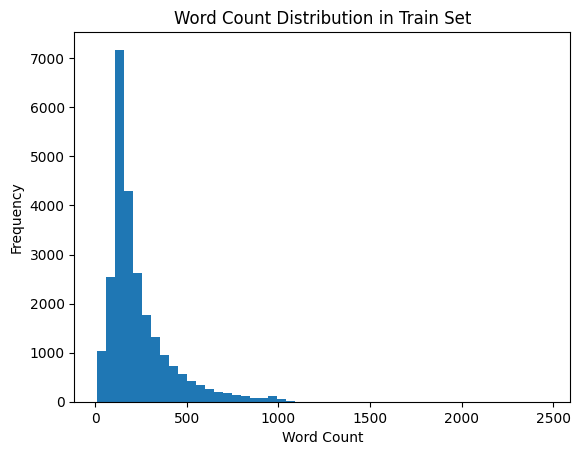

In [4]:
import matplotlib.pyplot as plt

# Compute word counts for each example in the training set
def compute_word_count(example):
    example["word_count"] = len(example["text"].split())
    return example

ds_train_word_counts = ds["train"].map(compute_word_count)
word_counts = ds_train_word_counts["word_count"]

# Plot the distribution
plt.hist(word_counts, bins=50)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution in Train Set")
plt.show()

In [5]:
def filter_under_300_words(example):
    return len(example["text"].split()) < 300

# Apply filtering to the full dataset
filtered_dataset = ds.filter(filter_under_300_words)

# Split into train and validation
filtered_train, filtered_val = filtered_dataset["train"].train_test_split(test_size=0.2, seed=42).values()

# Shuffle & select a smaller subset for training & validation
small_train_dataset = filtered_train.shuffle(seed=42).select(range(3000))
small_val_dataset = filtered_val.shuffle(seed=42).select(range(3000))

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

We will be limiting the word count since the model that will be used in the task has a token limit.

In [6]:
small_train_dataset[5]

{'text': 'My 3rd-year French classes always enjoyed this film very much. In a multi-cultural, inner-city high school, the film provided many subjects for discussion (in French in class, but I know a lot of discussion went on in English after class). The most obvious is the relationship between Protée and Aimée compared to the one between Protée and France.<br /><br />I always mentioned that I felt this film had one of the "sexiest" scenes I had ever seen in a movie. One year, a 17-year-old African-American shouted, "Yes!" when he figured out the scene: the one where Protée is helping Aimée lace up her evening dress, all the while both are examining the reflection of the other in the mirror. Directors use the "mirror technique" when then want to focus on the inner conflict on the part of one or more character in a scene: this is a perfect example of the technique, and it is "sexy".<br /><br />Most students had trouble understanding the end of the film. One suggested that one theme of th

In [7]:
small_val_dataset[5]

{'text': "This documentary was interesting, but it was also long (so long it lasts a total of 225 minutes), like Ben-Hur long. But if your into that, this is for you. But only if you have a passion for movies, like I do. Being that Martin Scorsese is my favorite director (live and maybe even ever), this is quite fascinating, especially if you know the style of Scorsese's works. Because then you can understand where he got his inspiration for many of his films. Not the best documentary film ever made, but it is a leap for Scorsese, which is always good to watch. A",
 'label': 1}

In [8]:
train_labels = small_train_dataset["label"]
val_labels = small_val_dataset["label"]

# Using Counter to count occurrences of each class
from collections import Counter

train_class_distribution = Counter(train_labels)
val_class_distribution = Counter(val_labels)  # Renamed from eval_class_distribution

print("Train Class Distribution:", train_class_distribution)
print("Validation Class Distribution:", val_class_distribution)

Train Class Distribution: Counter({0: 1520, 1: 1480})
Validation Class Distribution: Counter({0: 1506, 1: 1494})


This indicates that the classes are fairly balanced in both the training and evaluation datasets, we don't need to address class imbalance since the dataset seems evenly distributed.

## Preprocess the text

In [9]:
!pip install transformers --q

We will be using BERT which is a transformers model pretrained on a large corpus of English data in a self-supervised fashion.

In [10]:
from transformers import AutoTokenizer

# Define model name
model_name = "bert-base-uncased"

# BERT is great for text understanding, and "bert-base-uncased" is lightweight yet powerful.

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Test the tokenizer with a sample sentence
sample_text = "This movie was absolutely fantastic!"
tokens = tokenizer(sample_text)

print(tokens)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 2023, 3185, 2001, 7078, 10392, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [11]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization efficiently
tokenized_small_train_dataset = small_train_dataset.map(
    tokenize_function, batched=True, num_proc=4, remove_columns=["text"]
)

tokenized_small_val_dataset = small_val_dataset.map(
    tokenize_function, batched=True, num_proc=4, remove_columns=["text"]
)

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [12]:
# Convert dataset to PyTorch format
columns = ["input_ids", "attention_mask", "token_type_ids", "label"]

tokenized_small_train_dataset.set_format(type="torch", columns=columns)
tokenized_small_val_dataset.set_format(type="torch", columns=columns)

## Dataloader

In [13]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, get_scheduler
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_small_train_dataset,
    shuffle=True,
    batch_size=8,
    drop_last=True,  # Prevents last batch size mismatches
    pin_memory=True if torch.cuda.is_available() else False  # Optimizes GPU usage
)

val_dataloader = DataLoader(
    tokenized_small_val_dataset,
    batch_size=8,
    drop_last=False  # Keep all validation samples
)

In [15]:
# load a pre-trained model

model_name = "bert-base-uncased"

# This automatically replaces BERT’s original output layer with a new classification layer for the task.

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

 This output confirms that your BERT model is set up for binary classification.

In order to have full control over the training process and gain deeper understanding of how training works, we will use `manual training`. This could have also been done with Trainer API which automates what we're doing manually

In [16]:
# Weight decay helps regularize the model and reduce overfitting.
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

This setup ensures that the model training is regularized through weight decay, runs for a defined number of steps, and uses a learning rate that decays gradually to help stabilize training.


## Full Training Loop for Fine-Tuning BERT

In [17]:
# Early stopping parameters to prevent overfitting
best_val_loss = float("inf")
patience = 2  # Number of epochs with no improvement to wait before stopping
counter = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)

    # Training phase
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average training loss: {avg_train_loss:.4f}")

    # Evaluation phase
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1} average validation loss: {avg_val_loss:.4f}")

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="binary")
    precision = precision_score(all_labels, all_predictions, average="binary")
    recall = recall_score(all_labels, all_predictions, average="binary")
    print("Validation Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")

    # Early stopping check: if validation loss doesn't improve, increment counter.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset counter if improvement
        torch.save(model.state_dict(), "best_model.pth")  # Save best model when it improves
        print("New best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print(" Early stopping triggered")
            break

Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 average training loss: 0.4278
Epoch 1 average validation loss: 0.3175
Validation Metrics:
  Accuracy:  0.8780
  F1 Score:  0.8699
  Precision: 0.9273
  Recall:    0.8193
New best model saved!


Epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 average training loss: 0.1627
Epoch 2 average validation loss: 0.2617
Validation Metrics:
  Accuracy:  0.8920
  F1 Score:  0.8893
  Precision: 0.9079
  Recall:    0.8715
New best model saved!


Epoch 3:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3 average training loss: 0.0559
Epoch 3 average validation loss: 0.3431
Validation Metrics:
  Accuracy:  0.8980
  F1 Score:  0.8983
  Precision: 0.8918
  Recall:    0.9050


Epoch 4:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4 average training loss: 0.0100
Epoch 4 average validation loss: 0.4586
Validation Metrics:
  Accuracy:  0.8933
  F1 Score:  0.8893
  Precision: 0.9205
  Recall:    0.8601
 Early stopping triggered


## Model test on test data

In [28]:
# Filter original test split
filtered_test = ds["test"].map(compute_word_count).filter(filter_under_300_words)

# Shuffle & subset
small_test_dataset = filtered_test.shuffle(seed=42).select(range(3000))

# Tokenize & remove 'text'
tokenized_small_test_dataset = small_test_dataset.map(
    tokenize_function, batched=True, num_proc=4, remove_columns=["text"]
)

# Set format
tokenized_small_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids", "label"])

# Create test dataloader
test_dataloader = DataLoader(
    tokenized_small_test_dataset,
    batch_size=8
)

In [19]:
# Load the best saved model before testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Initialize lists for test predictions and labels
test_predictions = []
test_labels = []

# Run model on the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        preds = torch.argmax(outputs.logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(batch["label"].cpu().numpy())

# Compute final metrics on test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions, average="binary")

print(f" Final Test Accuracy: {test_accuracy:.4f}")
print(f" Final Test F1 Score: {test_f1:.4f}")

<ipython-input-19-2e665c3454cb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


 Final Test Accuracy: 0.8953
 Final Test F1 Score: 0.8946


For sentiment analysis (binary classification), anything above ~85% is strong.

F1 Score (0.8803) is high, meaning the model balances precision & recall well.

### Quick test on unseen reviews

In [33]:
# Load the best saved model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Sample unseen reviews
new_reviews = [
    "I absolutely loved this movie!",
    "The film was boring and too long",
    "An average experience, nothing spectacular"
]

# Tokenize input
inputs = tokenizer(new_reviews, padding=True, truncation=True, return_tensors="pt").to(device)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# Map labels
labels = ["Negative", "Positive"]
results = [labels[pred] for pred in predictions]

# Print results
for review, result in zip(new_reviews, results):
    print(f"Review: {review}\nPrediction: {result}\n")

<ipython-input-33-02c85d6152b8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


Review: I absolutely loved this movie!
Prediction: Positive

Review: The film was boring and too long
Prediction: Negative

Review: An average experience, nothing spectacular
Prediction: Negative



0 for negative, 1 for positive

## Uploading on HF

In [ ]:
# !pip install huggingface_hub

In [34]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# model.push_to_hub("Lpiziks2/imdb-bert-finetuned")
# tokenizer.push_to_hub("Lpiziks2/imdb-bert-finetuned")
# uploading on hf

## Deployment using Gradio

In [25]:
!pip install gradio --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch.nn.functional as F

# Load the best saved model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1)  # Convert logits to probabilities
        prediction = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][prediction].item()  # Get confidence score

    # Map prediction to a label
    label = "Positive" if prediction == 1 else "Negative"
    return f"{label} ({confidence:.2f} confidence)"

# Create the Gradio interface with probability output
interface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, placeholder="Enter a movie review here..."),
    outputs=gr.Textbox(label="Prediction"),
    title="Movie Review Sentiment Classifier",
    description="Enter a movie review and the model will predict whether the sentiment is Positive or Negative, along with confidence."
)

interface.launch(debug=True)

<ipython-input-35-3cfdd4cf57ca>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://79f543a5d5ec51b023.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
